# Mining relationships and improving prediction of financial instruments data
### Chen Wang, Yifeng Zhang, Yi Nian Lee, Haoran Xue

### Abstract 

In this challenge, we firstly use log-return to normalize the price data. Then, by using relations-network graphs in Azure and obtain the potentially predictable groups, the groups which have strong statistical predictability could be obtained. Further, by utilizing HISC Lasso, the valuable features could be selected and the noise features could be recognized and eliminated. In the predicting part, we used a gradient boosting classifier to train a machine learning model to predict the increments or decrements in the next 20 days for our selected predictable financial instruments. With fine-tuning of the parameters, we successfully trained our model which has a 68.75% accuracy of predicting test datasets. Furthermore, we model a Binomial-Levy stable model to measure the distributions of expected loss of our predicting model for model evaluation and risk control.

To sum up, there are several novel attributes that our model has obtained. Firstly, our model could hit an accuracy of 68.75%, remarkeably high for such time-series problem. Secondly, our model is well-explainable and has strong mathematical background. The HSIC method utilized in our model is designed for reflecting statistical independency, thus the theory of it is well-developed. And by dropping away somfeatures, we could not only improve the accuracy, but also obtain which features are strongly correlated. This property of our model perfectly answers the demands of the quesiton. Finally, we also utilized the Azure experiment tools and utilized its advantages.



In [108]:
#Import necessary modules
import pandas as pd 
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.cluster import k_means
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from azureml import Workspace
import scipy
from scipy.optimize import minimize
from scipy.optimize import fmin_cobyla
import math

## 1.Data clearning 

In [45]:
#Read basic-cleaned data
ws = Workspace()
ds = ws.datasets['dataset_clean.csv']
frame = ds.to_dataframe()

#restructure the data by time
Date = pd.to_datetime(frame.Date,  format='%Y%m%d')
frame.index = Date
frame = frame.iloc[:,1:]
#cleaning Na 
NA_dataframe = frame.isnull()
NA_clean = NA_dataframe.apply(axis =0,func=sum)
NA_clean.sort()
#get the top 200 less NA financial instruments
Top_Less_NA = NA_clean[:200].index
frame = frame[list(Top_Less_NA)]
frame = frame.fillna(axis =0,method='ffill')
frame = frame.fillna(axis =0,method='bfill')
frame.head()

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:13: FutureWarning:

sort is deprecated, use sort_values(inplace=True) for INPLACE sorting



,SLGTCATT Index,SLGTHOGS Index,USDCAD Curncy,USDAUD Curncy,USDJPY Curncy,USDGBP Curncy,USDEUR Curncy,USDNZD Curncy,USDHKD Curncy,USDMXN Curncy,...,DBK GR Equity,FPE GR Equity,MEO GR Equity,ADS GR Equity,CLS1 GR Equity,MAN GR Equity,DWNI GR Equity,MRK GR Equity,EBK GR Equity,FRA GR Equity
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,122000.0,416000.0,1.1659,1.2668,119.04,0.5104,0.7575,1.4191,7.7778,10.8073,...,89.485,8.668,50.95,37.79,40.44,69.12,26.322,39.363,49.714,55.08
2007-01-02,122000.0,416000.0,1.1655,1.2562,118.85,0.5067,0.7534,1.4146,7.7807,10.7743,...,89.485,8.668,50.95,37.79,40.44,69.12,26.322,39.363,49.714,55.08
2007-01-03,118000.0,413000.0,1.1734,1.2640,119.39,0.5124,0.7593,1.4153,7.7893,10.8174,...,89.580,8.843,49.86,37.92,40.22,70.20,27.962,39.949,50.161,54.97
2007-01-04,115000.0,415000.0,1.1775,1.2749,119.05,0.5147,0.7643,1.4317,7.7891,10.8994,...,89.815,8.818,50.14,37.79,41.38,69.43,27.093,42.118,50.151,54.22
2007-01-05,123000.0,414000.0,1.1732,1.2842,118.63,0.5183,0.7691,1.4575,7.7914,10.9305,...,89.015,8.958,49.99,37.40,41.30,68.60,27.093,42.541,50.101,54.22


## 1.1 Why we use log-return to normolize

1. Improving the fat tail and making data more stable.
2. Continuously Compounded Return: $S_{t+1}= S_{t}e^{rt},  r = log(S_{t+1} - S_{t})$. 
3. General Central Limit theorem.  $r_{t+n,t}= \sum_{t}^{t+n} r_{i} $ Then the distribution of r can be modelled as a four parameters stable distribution.

### Stable distribution
A random variable x is called stable if its characteristic function(Inverse of fourier transfermation) can be written as: 

$$ {\displaystyle \varphi (t;\alpha ,\beta ,c,\mu )=\exp \left(it\mu -|ct|^{\alpha }\left(1-i\beta \operatorname {sgn}(t)\Phi \right)\right)} $$
$${\displaystyle \Phi ={\begin{cases}\tan \left({\frac {\pi \alpha }{2}}\right)&\alpha \neq 1\\-{\frac {2}{\pi }}\log |t|&\alpha =1\end{cases}}}$$

This assumption can be used in parameter-estimation, regression estimation and error analysis.

### log-return periods and lags

According to many published papaer, financial instruments have a correlations in a short time periods and long time periods which means it is doable if we set log-return periods as month(20days) because we don't have high requency data. Setting monthly log-return can make prediction model more stable as well.

It is meanless of finding the relations of instruments in the same time-horizens, thus, we set 12 lags which is a year to mine the relations between instruments.

In [46]:
#Obtain the monthly(20days) log-return
log_return_data = np.log(frame)-np.log(frame.shift(1))
log_return_data = log_return_data.iloc[1:,:]
log_return_data = log_return_data.resample('20D').apply(sum)
#delet the data which have 0 variance for mathematical reason
variance = log_return_data.apply(axis=0, func=np.var)
#Remove low-variance features
log_return_data = log_return_data[variance[variance > 0].index]
#Setting lags
log_return_data.head()

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning:

divide by zero encountered in log

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning:

invalid value encountered in log



,USDCAD Curncy,USDAUD Curncy,USDJPY Curncy,USDGBP Curncy,USDEUR Curncy,USDNZD Curncy,USDHKD Curncy,USDMXN Curncy,USDSEK Curncy,USDTHB Curncy,...,DBK GR Equity,FPE GR Equity,MEO GR Equity,ADS GR Equity,CLS1 GR Equity,MAN GR Equity,DWNI GR Equity,MRK GR Equity,EBK GR Equity,FRA GR Equity
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-02,0.005560,-0.000553,0.018312,-0.007473,0.018702,0.013022,0.003875,0.008688,0.025627,-0.006935,...,0.020978,0.028321,0.041709,0.022243,0.035466,0.079508,0.077778,0.087094,-0.009032,0.068920
2007-01-22,0.000085,0.017227,0.003869,0.012554,-0.003895,0.017581,0.000704,0.008567,-0.004307,0.016341,...,0.013532,0.016461,0.002444,-0.019337,0.056150,0.161416,0.047700,0.054490,-0.010960,0.012630
2007-02-11,0.004085,-0.007481,-0.041178,0.002920,-0.014147,-0.006927,0.000192,0.019909,0.006652,-0.009406,...,-0.091238,-0.081561,-0.030895,-0.042307,0.007866,-0.087270,-0.201300,-0.003313,0.012156,0.004008
2007-03-03,-0.017134,-0.030576,0.011323,-0.010748,-0.010477,-0.033164,-0.000781,-0.018019,-0.009801,-0.022393,...,0.028117,0.149060,0.043955,0.066292,0.071274,0.084993,-0.029108,0.047947,-0.001603,-0.059927
2007-03-23,-0.015500,-0.021932,0.010610,-0.005319,-0.007494,-0.023028,0.000538,-0.000717,-0.010898,0.009189,...,0.039150,0.068250,-0.028388,0.102265,-0.008794,0.037466,0.007985,0.042019,0.015814,-0.009780


In [47]:
def name_new_columns(data, name):
    oldcolums = data.columns
    oldcolums = list(oldcolums)
    for i in range(len(oldcolums)):
        oldcolums[i] = oldcolums[i] + name
    newcolumns = oldcolums
    data.columns = newcolumns
    return data

Main_data = log_return_data
for i in range(12):
    shift_time = i + 1
    shift_data = log_return_data.shift(shift_time)
    name = '_' + np.str(shift_time)
    shift_data = name_new_columns(shift_data, name)
    Main_data = Main_data.join(shift_data)

Main_data = Main_data.iloc[19:,:]
Main_data.head()


,USDCAD Curncy,USDAUD Curncy,USDJPY Curncy,USDGBP Curncy,USDEUR Curncy,USDNZD Curncy,USDHKD Curncy,USDMXN Curncy,USDSEK Curncy,USDTHB Curncy,...,DBK GR Equity_12,FPE GR Equity_12,MEO GR Equity_12,ADS GR Equity_12,CLS1 GR Equity_12,MAN GR Equity_12,DWNI GR Equity_12,MRK GR Equity_12,EBK GR Equity_12,FRA GR Equity_12
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-17,-0.017019,-0.019811,-0.007647,-0.000786,0.000293,-0.012424,0.000423,-0.008630,0.003384,-0.006904,...,-0.087470,-0.034953,0.029724,0.009966,-0.026092,-0.017603,-0.119835,0.061564,0.065331,-0.062323
2008-02-06,-0.011676,-0.032649,0.011634,-0.001180,-0.012380,-0.037984,-0.000385,-0.006670,-0.027479,-0.018957,...,0.002051,0.039942,0.001308,0.038263,-0.005177,0.027281,0.053297,-0.011776,0.014454,0.008765
2008-02-26,-0.006950,-0.011093,-0.086751,-0.026110,-0.055337,-0.002194,-0.001951,-0.000659,-0.039676,-0.029286,...,-0.030238,0.131769,-0.008533,-0.050680,-0.051982,0.016204,-0.220830,-0.032201,0.006992,-0.012985
2008-03-17,0.019321,0.015625,0.023735,0.013041,-0.004084,0.030047,0.001182,-0.018751,-0.013146,0.009679,...,-0.057749,-0.130831,-0.076697,-0.033348,-0.055526,-0.084085,-0.066852,-0.048994,-0.008032,0.016394
2008-04-06,0.004945,-0.011323,0.028754,0.003780,0.006745,0.009427,0.000116,-0.009719,0.004674,0.001262,...,-0.085318,-0.016744,0.089307,-0.035215,0.033863,0.028199,-0.110559,-0.028893,0.000000,-0.084385


## 2. Relations minning 

After got the log-return data, we already moved the features of low-varuance and now we are going to mine the relations between output $S_{i,t=n}$ and $S_{j,t<n} (i \subset j)$. 
#### What is the goal of doing relation mining? 
The goal of doing a relations minning is to make predction more reiable and accurate, thus, in machine learning methods, the relations minning can be seen as a feature selection in our dataset because we have already put all of the potential variables in columns.

### 2.1 Possible methods

There is a lot of ways ....

### 2.1.1 Pearson correlations and spearman correlations. 

This one is simplest which use the Correlations Criteria: 


$$\rho ={\frac  {\sum _{i}(x_{i}-{\bar  {x}})(y_{i}-{\bar  {y}})}{{\sqrt  {\sum _{i}(x_{i}-{\bar  {x}})^{2}\sum _{i}(y_{i}-{\bar  {y}})^{2}}}}}.$$


Azure can help visulizing the results for us to find the relations much more easier. 

### 2.1.2 Linear regression model selection F test and goodness of fit R-square.

In the F test of linear regression, the $H_{0}$ is: the variable $X_{j,j}$ will not affect the model, the sum of error squres is the chisquare distribution:

$${\displaystyle f(x;\,k)={\begin{cases}{\dfrac {x^{(k/2-1)}e^{-x/2}}{2^{k/2}\Gamma \left({\frac {k}{2}}\right)}},&x>0;\\0,&{\text{otherwise}}.\end{cases}}}$$ 

and the chisquare distirbution divide chisquare distribution will be F distribution. 

$${\begin{aligned}f(x;d_{1},d_{2})&={\frac  {{\sqrt  {{\frac  {(d_{1}\,x)^{{d_{1}}}\,\,d_{2}^{{d_{2}}}}{(d_{1}\,x+d_{2})^{{d_{1}+d_{2}}}}}}}}{x\,{\mathrm  {B}}\!\left({\frac  {d_{1}}{2}},{\frac  {d_{2}}{2}}\right)}}\\&={\frac  {1}{{\mathrm  {B}}\!\left({\frac  {d_{1}}{2}},{\frac  {d_{2}}{2}}\right)}}\left({\frac  {d_{1}}{d_{2}}}\right)^{{{\frac  {d_{1}}{2}}}}x^{{{\frac  {d_{1}}{2}}-1}}\left(1+{\frac  {d_{1}}{d_{2}}}\,x\right)^{{-{\frac  {d_{1}+d_{2}}{2}}}}\end{aligned}}$$

Then we can get the P-value of F test, If we accpet $H_{0}$, it means the variable $X_{j,t}$ will not affect the explanary then they don't have correlations. 

The method of using R-square is similar, if the R square increass when we drop the $x_{j,t}$, then the $x_{j,t}$ will not be selected as a good input varibale.

However, there are many drawbacks of these method, it can only fit the linear relations, secondly it is computaional expensive, thridly it can not explor the cross-correlations between varibales. 

### 2.1.3  Markov random fields structure learning.

Markov random field is an undirected graphical model, we can use data to train structure and direction of model. However the computation is expensive and the assumption of all distributions will be complicated. 

### 2.2 Our method 

### Relations visulization and HISC LASSO features selection

The dimensions of this problem is really high, why don't we try some visuilization tools. 
We plot the heatmap and relations graph plot of correlations criteria, then finding the related explanary varibales and potential input. 

Because of the 1. sparsity of this time-series data We assume 2. few features should be more important, thus, we use HISC non-linear feature-wise Lasso to choose the model.

<b>HSIC Lasso Brief introduction</b>
$$ {{{min \atop \alpha \in \mathbb{R}^d} \frac{1}{2} ||  \overline{L} - \sum_{k = 1}^{d}\alpha_k\overline{K}^{(k)} || ^{2}_{Frob} + \lambda || \alpha||_1,} \atop {s.t  \alpha_1, ..., \alpha_d \geq 0}} $$

where $|| . ||_{Frob}$ is the Frobenius norm, $\overline{K}^{(k)} = \Gamma K^{(k)} \Gamma$ and $\overline{L} = \Gamma L \Gamma$ are centred Gram matrices.  This allows the selection of meaningful features of the Lasso. The $\overline{L}$ term allows us to regress the model by linear combinations of the second centred Gram matrix sum. 

<b>Interpretation of HSIC Lasso</b>

$$ {{\frac{1}{2}||\overline{L} - \sum_{k = 1}^{d} \overline{K}^{(k)}||^{2}_{Frob} = \frac{1}{2}HSIC(y,y) - \sum_{k = 1}^{d} \alpha_k HSIC(u_k, y) + \frac{1}{2} \sum_{k,l = 1}^{d}\alpha_k \alpha_l HSIC(u_k, u_l),} \atop {HSIC(u_k, y) = tr(\overline{K}^{(k)}) \overline{L}}}$$

$HSIC(u_k, y) = tr(\overline{K}^{(k)}\overline{L})$ is called the Hilbert-Schmidt Independence Criterion and it is a measure of independence between the two $\overline{K}^{(k)}$ and $\overline{L}$.
A nice benefit of using the HSIC Lsso is that we get to reduce redundant features in the output. 

<b>Kernel Seletion</b>

$$K(x, x') = exp ( - \frac{(x - x')^2}{2 \sigma_x^2})$$
$$L(y, y') = exp ( - \frac{(y - y')^2}{2 \sigma_y^2})$$
where $\sigma_x,\sigma_y$ are Gaussian kernel widths.
$$L(y,y') = 
\begin{cases}
{1/n_y}, & \text{if} y = y'\\
0, & \text{otherwise}
\end{cases}$$
$n_y$ is denoted as the number of samplesin class y.

<b>Computational Properties of HSIC Lasso</b>

$$ \frac{1}{2} || vec(\overline{L}) - [vec(\overline{K}^{(1)}), ..., vec(\overline{K}^{(d)})]\alpha ||_2^2$$

where vec(.) is the vectorisation operator. 
It is a proLsso perty of the HSIC Lasso that when d is larger than $n^2$, the optimisation technique is extremely efficient. In the case where there are more samples, we have to turn to other techniques because computation would now be resource taxing.

The centred Gram matrix for K can be rewritten as the following in efforts to use a lookup table for Gaussian Kernels 
$${{\begin{split}
\overline{K} & = (I - \frac{1}{n}ll^{\intercal})K(I = \frac{1}{n})ll^{\intercal}
& = K - lm^{\intercal} - ml^{\intercal} + sll^{\intercal},
\end{split}}\atop m = \frac{1}{n}Kl \in \mathbb{R}^{n},\text{   } s = \frac{1}{n^2}l^{\intercal}Kl \in \mathbb{R}}$$

<b>Variation: NOCCO Lasso</b>

$${{{min}\atop{\alpha \in \mathbb{R}^d}} \frac{1}{2} \sum_{k,l = 1}^{d}\alpha_k\alpha_l D^{NOCCO}(u_k, u_l) - \sum_{k = 1}^{d}\alpha_k D^{NOCCO}(u_k, y) + \lambda||\alpha||_l}\atop{s..t \text{  } \alpha_1,... ,\alpha_d \geq{0}}$$

where $D^{NOCCO}(u_k, y) = tr(\widetilde{K}^{(k)}\widetilde{L})$ is the kernel-based dependence measure based on the normalised cross-covariane operator (NOCCO). This Lasso is less sensitive to kernel choices unlike its HSIC counterpart.

<b>Other Types of Regularizers</b>

$${{{{min}\atop{\alpha \in \mathbb{R}^d}} \frac{1}{2}||\overline{L} - \sum_{k = 1}^{d}\alpha_k \overline{K}^{(k)}||^{2}_{Frob} + \lambda\sum_{g = 1}^{G}||\alpha_g ||_2 }
\atop{s.t. \alpha_1, ..., \alpha_d \geq{0}}}$$

where G is the number of groups. This is also easily solved by the Lasso optimisation strategy.

<b>Relation to Two-Stage Multiple Kernel Learning</b>

$${{{min}\atop{\alpha \in \mathbb{R}^d}} \frac{1}{2} \sum_{k,l = 1}^{d}\alpha_k\alpha_l HSIC(u_k, u_l) - \sum_{k = 1}^{d}\alpha_k HSIC(u_k, y)}\atop{s..t \text{  } \alpha_1,... ,\alpha_d \geq{0}}$$
This is the alternative to the Lasso DAL optimisation strategy and is particularly useful when the number of samples squared is far larger. This cTKA is convenient in that its feature selection can b eperformed by simply silving a nin-negative least-squared problem. It also has an assosiated Hessian matrixm D which can be written as 

$$ D = [vec(\overline{K}^{(1)}), ..., vec(\overline{K}^{(d)})]^\intercal[vec(\overline{K}^{(1)}), ..., vec(\overline{K}^{(d)})]$$

D will be singular when $n^2$ is small and may not be positive definite. For these reasons, cTKA is more suited for high-dimensional feature selection problems.

### Simple heatmap doesn't work in this high-dimensions case

According to the simple heatmap below, it is actually difficult to get the relations and potential preditable varibales from this plot.

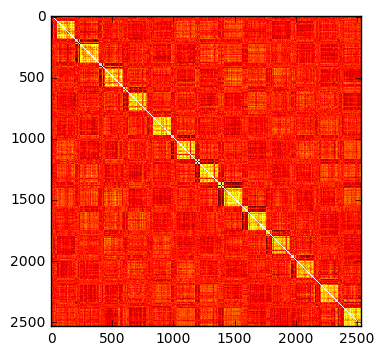

In [53]:
#heatmap for pearson correlations
r_map = Main_data.corr().values
plt.imshow(r_map, cmap='hot', interpolation='nearest')
plt.show()

### 2.3 Graph relations plot analysis in Azure

In [77]:
#obtain net_work data

for i in range(len(r_map)):
    r_map.iloc[i,i] = 0

network_matrix = np.abs(r_map) >= 0.6

net_work = list(np.zeros(shape=[0,2]))

for i in range(len(network_matrix)):
    for j in range(len(network_matrix)):
        if network_matrix.iloc[i,j] == True:
            x,y = network_matrix.columns[j],network_matrix.index[i]
            if x[-1] != y[-1]:
                net_work.append([x,y])
            else:
                pass
        else:
            pass

#### After using Azure to compute the relations graph, we can find 3 groups have good associations and have potential to be used for our predicting model.

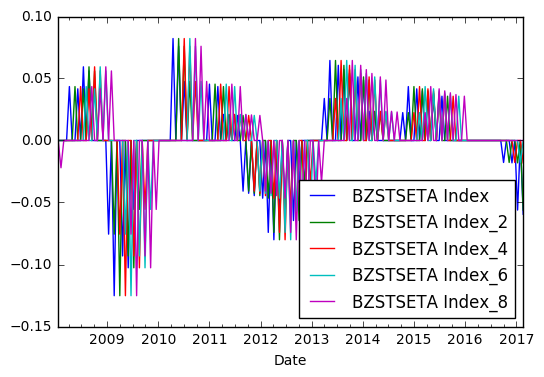

In [96]:
Main_data[['BZSTSETA Index','BZSTSETA Index_2','BZSTSETA Index_4','BZSTSETA Index_6','BZSTSETA Index_8']].plot()
plt.show()

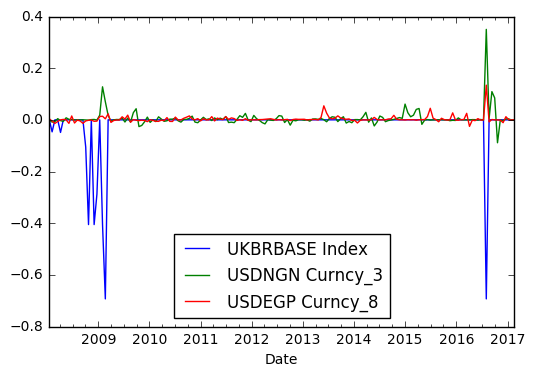

In [95]:
Main_data[['UKBRBASE Index','USDNGN Curncy_3','USDEGP Curncy_8']].plot()
plt.show()

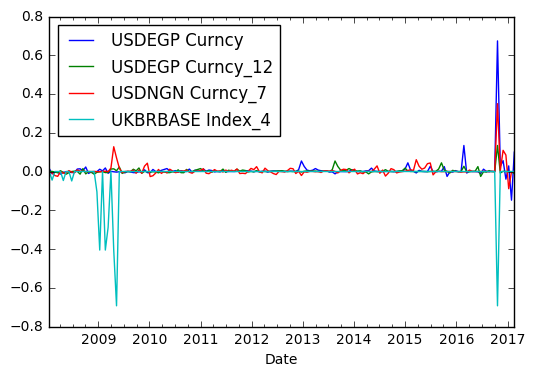

In [93]:
Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']].plot()
plt.show()

In [97]:
Data1 = Main_data[['BZSTSETA Index','BZSTSETA Index_2','BZSTSETA Index_4','BZSTSETA Index_6','BZSTSETA Index_8']]
Data2 = Main_data[['UKBRBASE Index','USDNGN Curncy_3','USDEGP Curncy_8']]
Data3 = Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']]

### 2.4 HSIC Lasso

In [81]:
###HSIC Lasso functions 

def GaussianKernel(x_left,x_right,sigma):
    xAmount = np.shape(x_left)[0]
    yAmount = np.shape(x_right)[0]
    #Define the Kernel Function
    Kernel = np.zeros((xAmount,yAmount))
    for i in range(xAmount):
        for j in range(yAmount):
            Kernel_left = x_left[i]    #1*n_Dim
            Kernel_right = x_right[j]   #1*n_Dim
            Kernel[i][j] = np.exp(-math.pow(np.linalg.norm(Kernel_left-Kernel_right),2))/(2*math.pow(sigma,2))
            
    return Kernel

def HSIC_Lasso(X,Y,para_lambda):
    #Calculate HSIC Lasso for feature selection
    #Reference (Proposer): Makoto Yamada, Kyoto University
    dataAmount = np.shape(X)[0]
    dataDim = np.shape(X)[1]
    #centering Matrix
    H = np.eye(dataAmount) - np.divide(np.ones((dataAmount,dataAmount)),dataAmount)
    #Calculate LH for y kernel
    L = GaussianKernel(Y,Y,0.01)
    global LH
    global lambda_p
    LH = np.dot(np.dot(H,L),H)
    lambda_p = para_lambda
    #Calculate KH dimension-wise
    global KH
    KH = []
    for cDim in range(dataDim):
        This_X = X[:,cDim]
        This_K = GaussianKernel(This_X,This_X,0.01)
        This_KH =  np.dot(np.dot(H,This_K),H)
        KH.append(This_KH)
    KH = np.asarray(KH)
    def HSIC_Lasso_func(alpha):
        #L m*m Matrix
        #nDim list of m*m Matrix
        #alpha = np.zeros((len(KH)))
        nData = int(math.sqrt(np.size(KH[0])))
        K_sum = np.zeros((nData,nData))
        for i in range(len(KH)):
            K_sum = K_sum + alpha[i]*KH[i]
        Function_norm = 0.5 * math.pow(np.linalg.norm(LH-K_sum),2)
        AlphaNorm =  np.linalg.norm(alpha,1)
        Func_ouput = Function_norm + lambda_p*AlphaNorm

        return Func_ouput
    #Consrust objective function  
    #func = HSIC_Lasso_func(LH,KH,para_lambda)
#     cons = ({'type': 'ineq',
#              'fun' : lambda alpha: [alpha[i] for i in range(np.shape(alpha)[0])]})
    def contraint(alpha):
        return [alpha[i] for i in range(np.shape(alpha)[0])]
    #res = fmin_cobyla(HSIC_Lasso_func, np.ones(np.shape(KH)[0]), constraints=cons, method='SLSQP', options={'disp': True})
    alpha_res = fmin_cobyla(HSIC_Lasso_func, np.ones(np.shape(KH)[0]), cons=contraint)
    
    
    return alpha_res


In [101]:
#Using HSIC LASSO

def caculate_HSIC(data):
    data = np.asarray(data)
    y = data[:,0]
    x = data[:,1:]
    HSIC_results = HSIC_Lasso(X=x, Y=y, para_lambda=100)
    print(HSIC_Lasso)
    return(HSIC_results)


In [102]:
caculate_HSIC(Data1)

<function HSIC_Lasso at 0x7f372b892e18>


array([  3.83688306e-01,  -7.34683969e-40,   0.00000000e+00,
         8.77325172e-39])

In [103]:
caculate_HSIC(Data2)

<function HSIC_Lasso at 0x7f372b892e18>


array([ 2.55257744,  0.86490622])

In [104]:
caculate_HSIC(Data3)

<function HSIC_Lasso at 0x7f372b892e18>


array([ 4.61267038,  0.93398364,  0.01844254])

## 3. Supervised learning

After the relations minning, we can do supervised learning to predict the models.
According to the results, we can build different models through GradientBoostingClassifier and GradientBoostingRegressor

### 3.1 Building model to predict USDEGP Curncy

### First simple model with features only based on correlations-network

In this simple model we use the all features detected by correlations-network and modelling a Gradient Boosting Classifier to predict the increasement or decreasement of USDGP in next 20 days

In [145]:
# data preparetion 
#deleting the last input varibale beacase of the result from HSIC
Data3 = Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']]
Data3 = np.asarray(Data3)

def trans_to_label(data):
    for i in range(len(data)):
        if data[i] >= 0: 
            data[i] = 1
        elif data[i] < 0:
            data[i] = -1
    return data

Train_x, Train_y = Data3[:150,1:] ,Data3[:150,0]
Test_x, Test_y = Data3[151:,1:] , Data3[151:,0]

Train_y = trans_to_label(Train_y)
Test_y = trans_to_label(Test_y)
#Simple modelling
classifier = GBC()
classifier.fit(X=Train_x, y= Train_y)
print('the accurcy of predicting training data:')
print(sum(classifier.predict(X=Train_x) == Train_y)/ len(Train_y))
print('the accurcy of predicting testing data:')
print(sum(classifier.predict(X=Test_x) == Test_y)/ len(Test_y))

the accurcy of predicting training data:
0.98
the accurcy of predicting testing data:
0.5


### simple model after using HSIC Lasso features selection

According to the results below, we found the HSIC actually really useful, when we delete the features which has the lowest HSIC-value, the predicting accurcy of training set decreased and the predicting accurcy of testing set increased.

In [149]:
# data preparetion 
#deleting the last input varibale beacase of the result from HSIC
Data3 = Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']]
Data3 = Data3.iloc[:,:-1]
Data3 = np.asarray(Data3)

def trans_to_label(data):
    for i in range(len(data)):
        if data[i] >= 0: 
            data[i] = 1
        elif data[i] < 0:
            data[i] = -1
    return data

Train_x, Train_y = Data3[:150,1:] ,Data3[:150,0]
Test_x, Test_y = Data3[151:,1:] , Data3[151:,0]

Train_y = trans_to_label(Train_y)
Test_y = trans_to_label(Test_y)
#Simple modelling
classifier = GBC()
classifier.fit(X=Train_x, y= Train_y)
print('the accurcy of predicting training data:')
print(sum(classifier.predict(X=Train_x) == Train_y)/ len(Train_y))
print('the accurcy of predicting testing data:')
print(sum(classifier.predict(X=Test_x) == Test_y)/ len(Test_y))

the accurcy of predicting training data:
0.966666666667
the accurcy of predicting testing data:
0.625


### Now paramter tuning time

In [153]:
# data preparetion 
#deleting the last input varibale beacase of the result from HSIC
Data3 = Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']]
Data3 = Data3.iloc[:,:-1]
Data3 = np.asarray(Data3)

def trans_to_label(data):
    for i in range(len(data)):
        if data[i] >= 0: 
            data[i] = 1
        elif data[i] < 0:
            data[i] = -1
    return data

Train_x, Train_y = Data3[:150,1:] ,Data3[:150,0]
Test_x, Test_y = Data3[151:,1:] , Data3[151:,0]

Train_y = trans_to_label(Train_y)
Test_y = trans_to_label(Test_y)
#Simple modelling

split = [0.5,2,3]
leaf = [1,2,3]
rate = [0.01,0.1,0.5]
dep = [2,3,4]

for i in split:
    for j in leaf:
        for k in rate:
            for z in dep:
                classifier = GBC(min_samples_split= i, min_samples_leaf=j, learning_rate=k, max_depth= z)
                classifier.fit(X=Train_x, y= Train_y)
                print('========================================')
                print('the accurcy of predicting training data:')
                print(sum(classifier.predict(X=Train_x) == Train_y)/ len(Train_y))
                print('the accurcy of predicting testing data:')
                print(sum(classifier.predict(X=Test_x) == Test_y)/ len(Test_y))
                print('params')
                print(i,j,k,z)
                print('========================================')

the accurcy of predicting training data:
0.7
the accurcy of predicting testing data:
0.3125
params
0.5 1 0.01 2
the accurcy of predicting training data:
0.7
the accurcy of predicting testing data:
0.3125
params
0.5 1 0.01 3
the accurcy of predicting training data:
0.726666666667
the accurcy of predicting testing data:
0.375
params
0.5 1 0.01 4
the accurcy of predicting training data:
0.826666666667
the accurcy of predicting testing data:
0.5
params
0.5 1 0.1 2
the accurcy of predicting training data:
0.893333333333
the accurcy of predicting testing data:
0.5
params
0.5 1 0.1 3
the accurcy of predicting training data:
0.92
the accurcy of predicting testing data:
0.5
params
0.5 1 0.1 4
the accurcy of predicting training data:
0.986666666667
the accurcy of predicting testing data:
0.5
params
0.5 1 0.5 2
the accurcy of predicting training data:
1.0
the accurcy of predicting testing data:
0.4375
params
0.5 1 0.5 3
the accurcy of predicting training data:
1.0
the accurcy of predicting testin

### Final model

After the parameter tuning, we got the best parameter for test dataset predicting.

In [156]:

Data3 = Main_data[['USDEGP Curncy','USDEGP Curncy_12','USDNGN Curncy_7','UKBRBASE Index_4']]
Data3 = Data3.iloc[:,:-1]
Data3 = np.asarray(Data3)

def trans_to_label(data):
    for i in range(len(data)):
        if data[i] >= 0: 
            data[i] = 1
        elif data[i] < 0:
            data[i] = -1
    return data

Train_x, Train_y = Data3[:150,1:] ,Data3[:150,0]
Test_x, Test_y = Data3[151:,1:] , Data3[151:,0]

Train_y = trans_to_label(Train_y)
Test_y = trans_to_label(Test_y)

split =2 
leaf = 1 
rate = 0.1
dep = 4 

classifier = GBC(min_samples_split= split , min_samples_leaf=leaf, learning_rate=rate, max_depth= dep)
classifier.fit(X=Train_x, y= Train_y)
print('========================================')
print('the accurcy of predicting training data:')
print(sum(classifier.predict(X=Train_x) == Train_y)/ len(Train_y))
print('the accurcy of predicting testing data:')
print(sum(classifier.predict(X=Test_x) == Test_y)/ len(Test_y))
print('========================================')


the accurcy of predicting training data:
1.0
the accurcy of predicting testing data:
0.6875


## 4. Model Evaluation

## 4.1 Why we don't do cross-validation 

We doubt the robustness of Cross-validation beacause the dataset is timeseries data. Thus, why don't we model the risk of using our model directly? 

## 4.2 Modelling model's risk directly :LDA  Loss Binomial-Levy Stable Density Model

According to the section 1.1  we assume the log-return is the stable distribution because of fat tailed and time series' properties. When we using the model, we assume the predicting mistakes are Binomial distribution and the loss should be stable distribution as the 1.1 assumption. Thus the distribution of loss from using this model should be a Loss Binomial Stable model.

Expected loss Z follow the distribution:

$$f_z(z) = \sum_{n = 1}^{M}p_n\left[\sqrt{\frac{\widetilde{\gamma_n}}{2 \pi}} \frac{1}{(z - \widetilde{\sigma_n}^{3/2})} exp\left( - \frac{\widetilde{\gamma_n}}{2(z - \widetilde{\gamma_n})}\right)\right] \times \mathbb{I}[\widetilde{\gamma_n} < z < \infty] $$

with 
$$p_n = C_{n}^{M}(p)^{n}(1-p)^{M-n}$$
$$\widetilde{\gamma_n}^{0.5} = \sum_{i = 1}^{n} \gamma_{i}^{0.5} = n|\gamma|^{0.5}, \widetilde{\beta_n} = 1$$
$$\widetilde{\sigma_n} = \sum_{i = 1}^{n} \sigma_i$ + tan\frac{\pi}{4}\left(\widetilde{\gamma_n} - \sum_{j=1}^{n}\gamma_j\right) - n\gamma + tan \frac{\pi}{4}(n^2|\gamma -n\gamma|)$$


Once we obtained the the distribution of expected loss of our model, then we can get the Expected shortfall of 95% significant level and measure the risk of our model. 

## 4.2.1 Monte Carlo methods to draw the samples from distribution Z

#### step0: estimated p(Mathematical analysis) and parameters of stable distribution from test dataset (MLE approach). 
#### step1: sample the p from the binomial distribution 
#### step2: sample the loss with prob P from stable distritbuion we estimated 
#### step3: get the mass distribution samples from Z 

After obtain the distributions from Z, we can use VAR or CVAR to measure the risk of our models. 